In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from math import sqrt

In [19]:
ticker = 'GOOG'
start_date = '2018-01-01'
end_date = '2023-10-31'

In [5]:
df = yf.download(ticker, start_date, end_date).reset_index()
df

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,52.417000,53.347000,52.261501,53.250000,53.250000,24752000
1,2018-01-03,53.215500,54.314499,53.160500,54.124001,54.124001,28604000
2,2018-01-04,54.400002,54.678501,54.200100,54.320000,54.320000,20092000
3,2018-01-05,54.700001,55.212502,54.599998,55.111500,55.111500,25582000
4,2018-01-08,55.111500,55.563499,55.081001,55.347000,55.347000,20952000
...,...,...,...,...,...,...,...
1462,2023-10-24,139.160004,140.710007,138.750000,140.119995,140.119995,26535200
1463,2023-10-25,129.770004,130.100006,126.089996,126.669998,126.669998,58796100
1464,2023-10-26,124.470001,125.459999,122.320000,123.440002,123.440002,33907400
1465,2023-10-27,124.029999,124.440002,121.459999,123.400002,123.400002,37367700


In [6]:
data = df['Close']

scaler = MinMaxScaler()
data = scaler.fit_transform(data.values.reshape(-1, 1))

In [7]:
training_data_len = int(len(data) * 0.8)
training_data = data[0:training_data_len, :]
testing_data = data[training_data_len:, :]

len(training_data), len(testing_data)

(1173, 294)

In [8]:
past_values = 1

def create_training_data(data, past_values):
    if len(data) < past_values:
        return np.array([]), np.array([])
    X_train = []
    y_train = []
    for i in range(past_values, len(data)):
        X_train.append(data[i-past_values:i, 0])
        y_train.append(data[i, 0])
    return np.array(X_train), np.array(y_train)

X_train, y_train = create_training_data(training_data, past_values)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

X_test, y_test = create_training_data(testing_data, past_values)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [9]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=200, epochs=200, verbose=1)

Epoch 1/200
6/6 [==============================] - 20s 17ms/step - loss: 0.2087
Epoch 2/200
6/6 [==============================] - 0s 19ms/step - loss: 0.1677
Epoch 3/200
6/6 [==============================] - 0s 16ms/step - loss: 0.1297
Epoch 4/200
6/6 [==============================] - 0s 16ms/step - loss: 0.0996
Epoch 5/200
6/6 [==============================] - 0s 15ms/step - loss: 0.0861
Epoch 6/200
6/6 [==============================] - 0s 16ms/step - loss: 0.0834
Epoch 7/200
6/6 [==============================] - 0s 22ms/step - loss: 0.0738
Epoch 8/200
6/6 [==============================] - 0s 18ms/step - loss: 0.0606
Epoch 9/200
6/6 [==============================] - 0s 18ms/step - loss: 0.0453
Epoch 10/200
6/6 [==============================] - 0s 17ms/step - loss: 0.0260
Epoch 11/200
6/6 [==============================] - 0s 15ms/step - loss: 0.0089
Epoch 12/200
6/6 [==============================] - 0s 16ms/step - loss: 0.0012
Epoch 13/200
6/6 [==============================

6/6 [==============================] - 0s 15ms/step - loss: 2.7687e-04
Epoch 196/200
6/6 [==============================] - 0s 15ms/step - loss: 2.8277e-04
Epoch 197/200
6/6 [==============================] - 0s 16ms/step - loss: 2.9019e-04
Epoch 198/200
6/6 [==============================] - 0s 18ms/step - loss: 2.8093e-04
Epoch 199/200
6/6 [==============================] - 0s 19ms/step - loss: 2.7709e-04
Epoch 200/200
6/6 [==============================] - 0s 16ms/step - loss: 2.8054e-04


In [10]:
pred_train = model.predict(X_train)
pred = model.predict(X_test)

10/10 [==============================] - 0s 4ms/step


In [11]:
pred_train = scaler.inverse_transform(pred_train)
pred = scaler.inverse_transform(pred)
y_test = scaler.inverse_transform([y_test])
y_train = scaler.inverse_transform([y_train])

In [12]:
y_test = y_test.flatten()
y_train = y_train.flatten()

Training Error
Mean Absolute Error (MAE): 1.1418379988686624
Root Mean Squared Error (RMSE): 1.6864476661362278


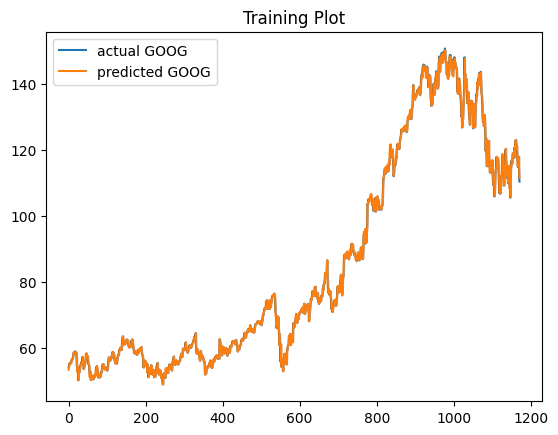

In [13]:
print("Training Error")
mae = mean_absolute_error(y_train, pred_train)
print("Mean Absolute Error (MAE):", mae)
rmse = sqrt(mean_squared_error(y_train, pred_train))
print("Root Mean Squared Error (RMSE):", rmse)
    
plt.plot(y_train, label = 'actual '+str(ticker))
plt.plot(pred_train, label = 'predicted '+str(ticker))
plt.title("Training Plot")
plt.legend()
plt.show()

Testing Error
Mean Absolute Error (MAE): 1.7293194455091454
Root Mean Squared Error (RMSE): 2.361972566663376


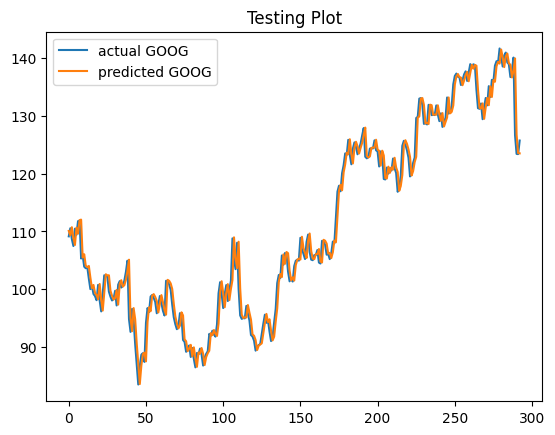

In [14]:
print("Testing Error")
mae = mean_absolute_error(y_test, pred)
print("Mean Absolute Error (MAE):", mae)
rmse = sqrt(mean_squared_error(y_test, pred))
print("Root Mean Squared Error (RMSE):", rmse)

plt.plot(y_test, label = 'actual '+str(ticker))
plt.plot(pred, label = 'predicted '+str(ticker))
plt.title("Testing Plot")
plt.legend()
plt.show()

In [15]:
y_test[-1]

125.75

In [16]:
pred[-1]

array([123.5284], dtype=float32)

In [20]:
start_date = '2023-11-01'
end_date = '2023-12-08'
future_data = yf.download(ticker, start_date, end_date).reset_index()['Close']
future_data

[*********************100%***********************]  1 of 1 completed


0     127.570000
1     128.580002
2     130.369995
3     131.449997
4     132.399994
5     133.259995
6     131.690002
7     134.059998
8     133.639999
9     135.429993
10    136.380005
11    138.699997
12    136.940002
13    137.919998
14    138.619995
15    140.020004
16    138.220001
17    138.050003
18    138.619995
19    136.399994
20    133.919998
21    133.320007
22    130.630005
23    132.389999
24    131.429993
25    138.449997
Name: Close, dtype: float64

In [21]:
future_data = np.array(future_data)
len(future_data)

26

In [22]:
# model(april1) = (april2-pred) -> april2actual



# model(april2-pred) = april3-pred

In [23]:
def predict_future(days, last_input, future_data):
    Output = []
    i = 0
    temp = scaler.transform(future_data.reshape(-1, 1))
    
    while(i<days):
        if(len(last_input)>past_values):
            last_input = last_input[1:]
            last_input = last_input.reshape((1, past_values, 1))
            res = model.predict(last_input)
            last_input = np.append(last_input, temp[i])
            last_input = last_input[1:]
            Output.extend(res.tolist())
            i=i+1
        else:
            last_input = last_input.reshape((1, past_values, 1))
            res = model.predict(last_input)
            last_input = np.append(last_input, temp[i])
            Output.extend(res.tolist())
            i=i+1
        
    Output = scaler.inverse_transform(Output)
    return Output, last_input
    
future_predictions, last_input = predict_future(len(future_data), X_test[-1], future_data)
future_predictions = future_predictions.flatten()

1/1 [==============================] - 0s 34ms/step


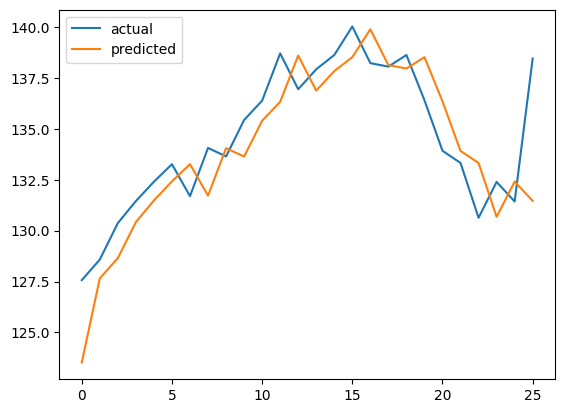

In [24]:
plt.plot(future_data, label = 'actual')
plt.plot(future_predictions, label = 'predicted')
plt.legend()
plt.show()

In [25]:
def get_control_vector(val):
    return np.diff(np.sign(np.diff(val)))

def buy_and_sell_bot(val,controls):
    inv = []
    curr_val = 1000
    inds = np.where(controls)[0]
    buy_inds = np.where(controls>0)[0]
    sell_inds = np.where(controls<0)[0]
    max_limit = sell_inds[-1] if sell_inds[-1]>buy_inds[-1] else buy_inds[-1]
    for i in range(buy_inds[0]+2):
        inv.append(curr_val)
    for i in range(buy_inds[0],max_limit+1):
        if controls[i]>0:
            buy_val = val[i+1]
        elif controls[i]<0:
            sell_val = val[i+1]
            curr_val = curr_val*sell_val/buy_val
        inv.append(curr_val)
        
    if max_limit+1!=len(controls):
        for i in range(len(controls)-max_limit-1):
            inv.append(curr_val)
    return inv

In [26]:
controls_actual = get_control_vector(future_data)
amount_actual = buy_and_sell_bot(future_data, controls_actual)

In [27]:
controls_pred= get_control_vector(future_predictions)
amount_pred = buy_and_sell_bot(future_predictions, controls_pred)

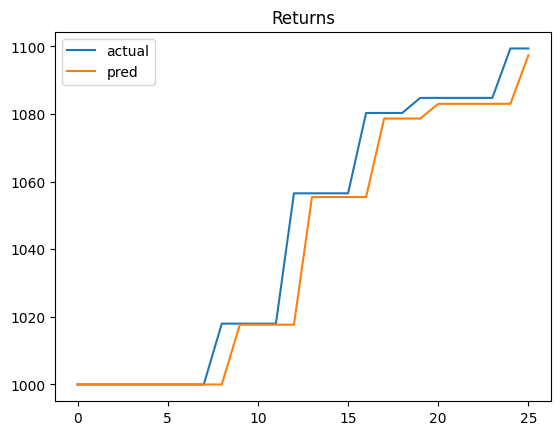

In [28]:
plt.plot(amount_actual, label="actual")
plt.plot(amount_pred, label="pred")
plt.legend()
plt.title("Returns")
plt.show()